In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

In [3]:
# Load data (example)
LOAD = 'screen'

if LOAD == 'samples':
    mysamples = {
        'CTRL' : '../data/samples/PBMC.mtx',
        'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
        'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
        'IL2_10ng/ml' : '../data/samples/IL2.mtx',
        'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
    }
    mygenes = '../data/samples/genes.tsv'
    pop = PA.load_samples(samples=mysamples, 
                          genes=mygenes)
    
elif LOAD == 'screen':
    mymatrix = '../data/screen/drug_screen/pbmcmult4cd3minus.mtx'
    mybarcodes = '../data/screen/drug_screen/barcodes.tsv'
    mygenes = '../data/screen/drug_screen/features.tsv'
    mymetadata = '../data/screen/drug_screen/meta.csv'
    pop = PA.load_screen(matrix=mymatrix, 
                         barcodes=mybarcodes, 
                         metafile=mymetadata, 
                         genes=mygenes)

In [4]:
# Perform column normalization
# Find best normalization factor
PA.normalize(pop)

Performing column normalization
Finding best normalization factor


2666 genes selected


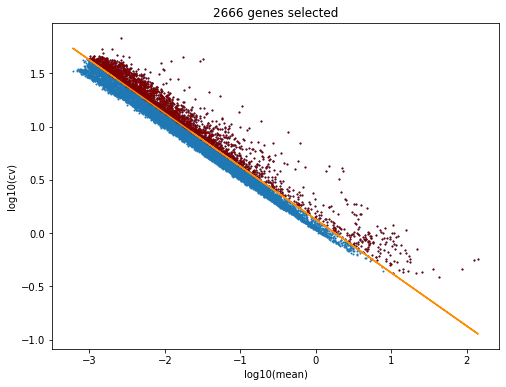

In [5]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
PA.plot_gene_filter(pop, offset=1.1)

In [6]:
# Gene filter the data with the last offset value used in the previous step
PA.filter(pop)

Removing ribosomal genes
Filtering genes ang logging data


In [7]:
# Remove red blood cells from the data
PA.removeRBC(pop, 'human')

Meprednisone 943 cells kept out of 943
Dexrazoxane HCl (ICRF-187, ADR-529) 720 cells kept out of 720
Etodolac 898 cells kept out of 898
Phenylbutazone 671 cells kept out of 671
Pomalidomide 804 cells kept out of 804
Budesonide 726 cells kept out of 726
Loteprednol etabonate 646 cells kept out of 646
CTRL 3584 cells kept out of 3585
Betamethasone Valerate 1004 cells kept out of 1004
Febuxostat 848 cells kept out of 848
Sulfasalazine 796 cells kept out of 796
Flurbiprofen 834 cells kept out of 834
Mianserin HCl 744 cells kept out of 744
Naproxen Sodium 670 cells kept out of 670
Triamcinolone Acetonide 866 cells kept out of 866
Acetylcysteine 903 cells kept out of 903
Everolimus (RAD001) 486 cells kept out of 486
Isotretinoin 927 cells kept out of 927
Ibuprofen 893 cells kept out of 893
Doramapimod (BIRB 796) 908 cells kept out of 908
Allopurinol Sodium 666 cells kept out of 666
Tranilast 1081 cells kept out of 1081
Cyclosporine 738 cells kept out of 738
Adapalene 806 cells kept out of 80

In [8]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=300)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #299
......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Computing reconstruction errors
Progress: 1 of 6
Progress: 2 of 6
Progress: 3 of 6
Progress: 4 of 6
Progress: 5 of 

In [17]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
importlib.reload(PA) 
PA.build_gmms(pop, 
              ks=(5,20), 
              niters=3, 
              training=.8, 
              nreplicates=3, 
              reg_covar=True, 
              rendering='grouped', 
              types=None)

Building model for Meprednisone (1 of 41)
Building model for Dexrazoxane HCl (ICRF-187, ADR-529) (2 of 41)
Building model for Etodolac (3 of 41)
Building model for Phenylbutazone (4 of 41)
Building model for Pomalidomide (5 of 41)
Building model for Budesonide (6 of 41)
Building model for Loteprednol etabonate (7 of 41)
Building model for CTRL (8 of 41)
Building model for Betamethasone Valerate (9 of 41)
Building model for Febuxostat (10 of 41)
Building model for Sulfasalazine (11 of 41)
Building model for Flurbiprofen (12 of 41)
Building model for Mianserin HCl (13 of 41)
Building model for Naproxen Sodium (14 of 41)
Building model for Triamcinolone Acetonide (15 of 41)
Building model for Acetylcysteine (16 of 41)
Building model for Everolimus (RAD001) (17 of 41)
Building model for Isotretinoin (18 of 41)
Building model for Ibuprofen (19 of 41)
Building model for Doramapimod (BIRB 796) (20 of 41)
Building model for Allopurinol Sodium (21 of 41)
Building model for Tranilast (22 of 41)


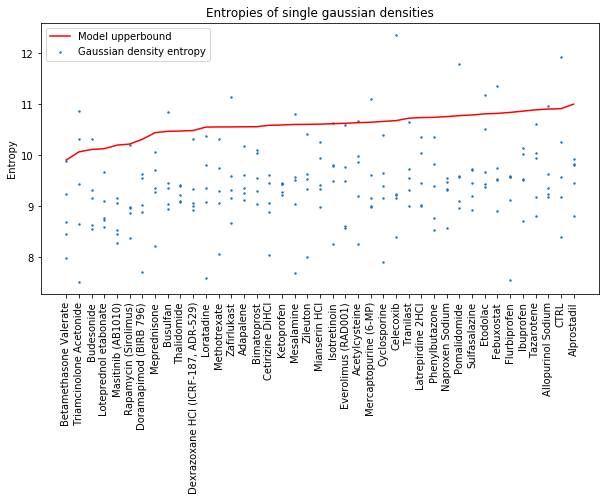

In [44]:
# Calculate all the subpopulations entropies for each samples
importlib.reload(PA)
PA.entropy(pop)

In [136]:
# Align subpopulations of each sample against a reference model's subpopulations
importlib.reload(PA)
PA.align(pop, ref='CTRL', method='conservative')

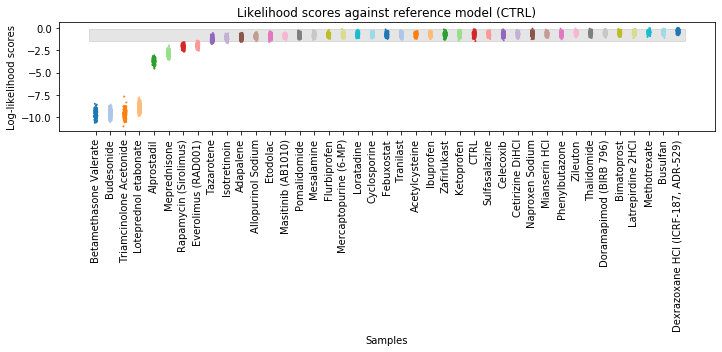

In [19]:
# Rank each sample against a reference sample's model
PA.rank(pop, ref='CTRL', k=100, niter=200, mincells=50)

In [9]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, ks=(5,20), niters=3, reg_covar=True, types=None)

In [176]:
# Generate a query plot
importlib.reload(PA)
PA.plot_query(pop)
PA.plot_query_heatmap(pop)

Plot saved under output/query/query_plot.pdf
Plot saved under output/query/query_heatmap.pdf


In [ ]:
# Interactive 3D visualization of the data in feature space
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

In [46]:
import os
import csv
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import io as sio
from scipy import sparse as ss
from scipy import optimize as so
from scipy import stats
from scipy.stats import linregress
from scipy.cluster import hierarchy as shc
from scipy.spatial import distance as scd
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import mixture as smix
import fastcluster as fc
from sklearn import cluster as sc
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
import adjustText
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout, HBox, VBox, fixed
from textwrap import wrap
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.offline import iplot

In [ ]:
def l1norm()

In [177]:
pop['ref']

'CTRL'

In [197]:
x1 = pop['ref']

i1, i2 = pop['samples'][xtest]['alignments'][0][:2]
M1 = pop['samples'][xtest]['M']
M2 = pop['samples'][xref]['M']

prediction1 = pop['samples'][xtest]['gmm'].predict(pop['samples'][xtest]['C'])
idx1 = np.where(prediction1==i1)
sub1 = M1[:,idx1]

prediction_ref = pop['samples'][xref]['gmm'].predict(pop['samples'][xref]['C'])
idxref = np.where(prediction_ref==iref)
subref = 

subtest = 

In [201]:
g = 'CD3D'
ig = np.where(pop['genes']==g)[0][0]

In [202]:
ig

19801